In [1]:
import os
from scipy import ndimage
import nibabel as nib
from keras.utils import get_file
import torchio as tio
import numpy as np
import zipfile

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
url_1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
url_2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

file_path = "c:\\Users\\maxim\\OneDrive\\Desktop\\Research\\Experiment_1\\datasets\\CT-0.zip"
if os.path.exists(file_path):
    os.remove(file_path)  # Deletes the incomplete file

# Directory where the files will be stored
cache_dir = os.getcwd()  # Current working directory

# Download the first file
filename_1 = get_file("CT-0.zip", url_1, cache_dir=cache_dir)

# Download the second file
filename_2 = get_file("CT-23.zip", url_2, cache_dir=cache_dir)

# Make a directory to store the data
os.makedirs("CT_Data", exist_ok=True)  # Using exist_ok=True to avoid errors if the directory exists

# Unzip the first file
with zipfile.ZipFile(filename_1, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

# Unzip the second file
with zipfile.ZipFile(filename_2, "r") as z_fp:
    z_fp.extractall("./CT_Data/")

In [15]:
# Function to load a .nii.gz file
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

def save_nii(volume, save_path):
    new_img = nib.Nifti1Image(volume, np.eye(4))  # Assuming the affine matrix is identity
    nib.save(new_img, save_path)

def elastic_deformation(volume, num_control_points=5, max_displacement=10):
    """
    Apply elastic deformation to a volume (e.g., CT scan).
    :param volume: The input volume (e.g., a 3D numpy array or torch tensor).
    :param num_control_points: Number of control points used for the deformation.
    :param max_displacement: Maximum displacement (in voxels).
    :return: Deformed volume.
    """
    transform = tio.RandomElasticDeformation(num_control_points=num_control_points, max_displacement=max_displacement)
    
    # Add a channel dimension: (1, depth, height, width)
    volume_tio = tio.ScalarImage(tensor=volume[np.newaxis, ...])  
    transformed_volume = transform(volume_tio)  # Apply elastic deformation
    
    # Remove channel dimension before returning
    return transformed_volume.tensor.numpy()[0]

def random_flip(volume, flip_probability=0.5):
    """
    Apply random flipping (horizontal/vertical) to the volume.
    
    :param volume: The input volume (3D numpy array).
    :param flip_probability: Probability of applying the flip.
    :return: Flipped volume.
    """
    if np.random.rand() < flip_probability:
        # Flip the volume along random axes (x, y, or z)
        axis = np.random.choice([0, 1, 2])  # Randomly choose axis to flip
        volume = np.flip(volume, axis=axis)  # Flip along the selected axis
    return volume

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = load_nii(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [16]:
def create_multiview_dataset(base_path, ct_folders):
    for ct_folder in ct_folders:
        folder_path = os.path.join(base_path, ct_folder)
        # List all items in the folder and process only files (not directories)
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # Skip hidden files (those starting with a dot) and directories
            if item.startswith('.') or os.path.isdir(item_path):
                continue  # Skip hidden files or directories

            if os.path.isfile(item_path) and item.endswith('.nii.gz'):  # Check if it's a .nii.gz file
                try:
                    # Load the original CT scan image
                    original_volume = process_scan(item_path)

                    # Create subdirectory for each file (based on the file name without extension)
                    study_dir_name = os.path.splitext(item)[0]  # Get the file name without extension
                    study_save_dir = os.path.join(folder_path, study_dir_name)
                    os.makedirs(study_save_dir, exist_ok=True)

                    # Save the original image
                    save_nii(original_volume, os.path.join(study_save_dir, f"{study_dir_name}_original.nii.gz"))

                    # Save the elastic image
                    elastic_volume = elastic_deformation(original_volume)
                    save_nii(elastic_volume, os.path.join(study_save_dir, f"{study_dir_name}_elastic.nii.gz"))

                    # Save the flipped image
                    flip_volume = random_flip(original_volume)
                    save_nii(flip_volume, os.path.join(study_save_dir, f"{study_dir_name}_flipped.nii.gz"))

                except Exception as e:
                    print(f"Error processing {item_path}: {e}")

# Directory structure
base_directory = "CT_Data"
ct_folders = ["CT-0", "CT-23"]

# Create multi-view dataset
create_multiview_dataset(base_directory, ct_folders)

In [17]:
base_path = './CT_Data/CT-0'
base_path_2 = './CT_Data/CT-23'


def delete_files(base_path):

    # Iterate through the files in CT_Data
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        # Check if it's a file and if it ends with '.gz'
        if os.path.isfile(item_path) and item.endswith('.gz'):
            os.remove(item_path)  # Delete the file
            print(f"Deleted file: {item_path}")


delete_files(base_path)
delete_files(base_path_2)

Deleted file: ./CT_Data/CT-0\study_0001.nii.gz
Deleted file: ./CT_Data/CT-0\study_0002.nii.gz
Deleted file: ./CT_Data/CT-0\study_0003.nii.gz
Deleted file: ./CT_Data/CT-0\study_0004.nii.gz
Deleted file: ./CT_Data/CT-0\study_0005.nii.gz
Deleted file: ./CT_Data/CT-0\study_0006.nii.gz
Deleted file: ./CT_Data/CT-0\study_0007.nii.gz
Deleted file: ./CT_Data/CT-0\study_0008.nii.gz
Deleted file: ./CT_Data/CT-0\study_0009.nii.gz
Deleted file: ./CT_Data/CT-0\study_0010.nii.gz
Deleted file: ./CT_Data/CT-0\study_0011.nii.gz
Deleted file: ./CT_Data/CT-0\study_0012.nii.gz
Deleted file: ./CT_Data/CT-0\study_0013.nii.gz
Deleted file: ./CT_Data/CT-0\study_0014.nii.gz
Deleted file: ./CT_Data/CT-0\study_0015.nii.gz
Deleted file: ./CT_Data/CT-0\study_0016.nii.gz
Deleted file: ./CT_Data/CT-0\study_0017.nii.gz
Deleted file: ./CT_Data/CT-0\study_0018.nii.gz
Deleted file: ./CT_Data/CT-0\study_0019.nii.gz
Deleted file: ./CT_Data/CT-0\study_0020.nii.gz
Deleted file: ./CT_Data/CT-0\study_0021.nii.gz
Deleted file:

In [18]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Example usage:
path = "CT_Data/CT-23"
path2 = "CT_Data/CT-0"
print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 100
Number of directories: 100


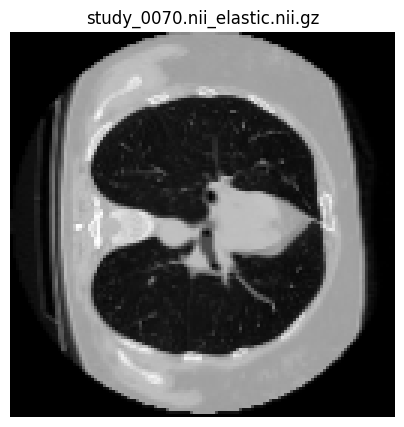

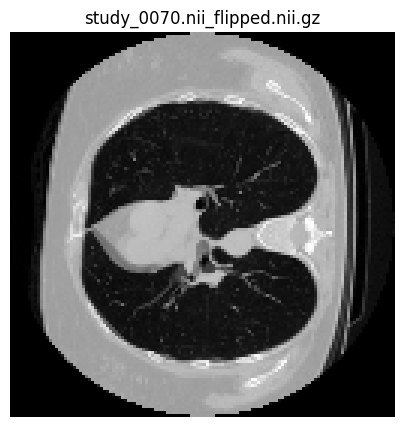

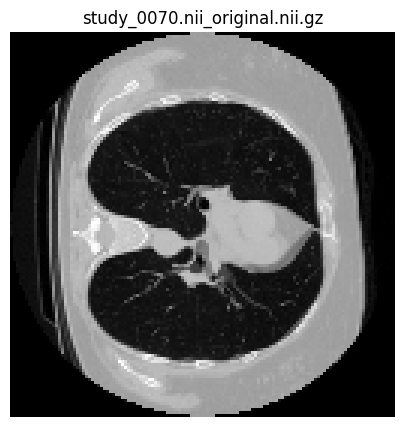

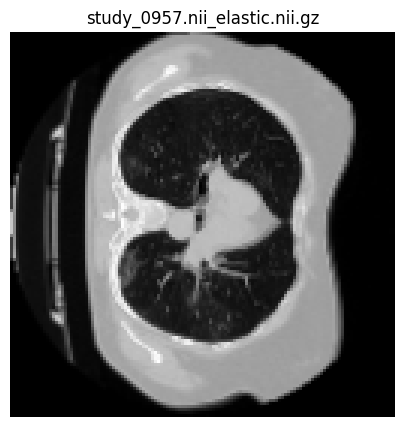

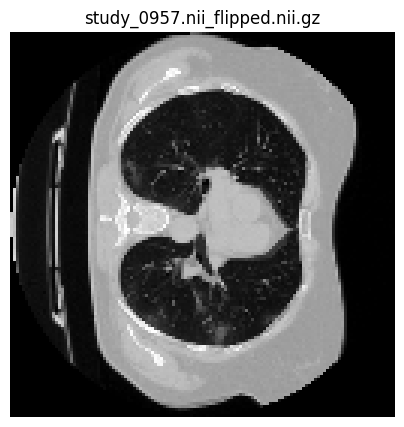

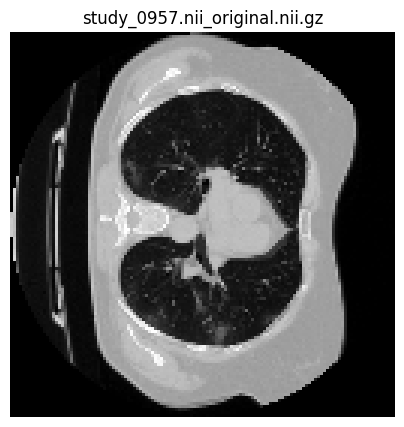

In [7]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

# Function to load and plot the NIfTI files from the specified directory
def plot_ct_scans_from_directory(study_dir):
    # Get all the .nii files in the directory
    nii_files = [f for f in os.listdir(study_dir) if f.endswith('.nii.gz')]
    
    # Plot each file
    for nii_file in nii_files:
        # Load the NIfTI file
        nii_path = os.path.join(study_dir, nii_file)
        img = nib.load(nii_path)
        volume = img.get_fdata()

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.set_title(nii_file)
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./CT_Data/CT-0/study_0070.nii"

plot_ct_scans_from_directory(study_directory)

study_directory = "./CT_Data/CT-23/study_0957.nii"

plot_ct_scans_from_directory(study_directory)